# BERT for fake news detection


Make sure that you are using GPU

In [1]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

You can see the type of gpu available for you:

In [2]:
!nvidia-smi

Sat Jul  9 09:10:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Load the data

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
root = 'drive/My Drive/Colab Notebooks/'
reda_root = 'drive/My Drive/TFG/'
paht = 'drive/My Drive/Colab Notebooks/fakkedit/'

Mounted at /content/drive


In [5]:
MULTIMODAL_ONLY = True # if False, we will load all the
nameFile = 'multimodal_'
if not MULTIMODAL_ONLY:
    nameFile ='all_'


In [6]:
import pandas as pd
train = pd.read_csv(reda_root+"data/fakeddit/" + nameFile+ "train.tsv", sep='\t')
val  = pd.read_csv(reda_root+"data/fakeddit/" + nameFile+ "validate.tsv", sep='\t')
test  = pd.read_csv(reda_root+"data/fakeddit/" + nameFile+ "test_public.tsv", sep='\t')

print("Dataset: ", nameFile)
print('size training: ', len(train))
print('size validation: ', len(val))
print('size test: ', len(test))


Dataset:  multimodal_
size training:  564000
size validation:  59342
size test:  59319


To make faster experimentation, we reduce the size of the datasets (of course, the results will be worse)

In [7]:
import numpy as np
reduction = 10 #100, 10 or 1

print("reduction applied: ", reduction)


print(f"Training patterns before reduction: {len(train)}")
train = train.sample(int(len(train)/reduction), random_state=12345)
print(f"Training patterns after reduction:  {len(train)}")

print(f"Validation patterns before reduction: {len(val)}")
val = val.sample(int(len(val)/reduction), random_state=12345)
print(f"Validation patterns after reduction:  {len(val)}")

print(f"Test patterns before reduction: {len(test)}")
test = test.sample(int(len(test)/reduction), random_state=12345)
print(f"Test patterns after reduction:  {len(test)}")

reduction applied:  10
Training patterns before reduction: 564000
Training patterns after reduction:  56400
Validation patterns before reduction: 59342
Validation patterns after reduction:  5934
Test patterns before reduction: 59319
Test patterns after reduction:  5931


In [8]:
train.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
224716,T3nd0o,this basket made out of old candy wrappers fea...,1.566649e+09,i.redd.it,True,cusqgc,https://preview.redd.it/vz64u4m03ei31.jpg?widt...,NaN,2.0,20,mildlyinteresting,This basket made out of old candy wrappers (fe...,0.80,1,0,0
525216,TindalosKeeper,ugh shitty connection,1.560360e+09,NaN,True,eqwq1xm,https://i.imgur.com/jhHIGoj.jpg,bzptls,NaN,8,psbattle_artwork,"Ugh, shitty connection!",NaN,0,2,4
104777,ZAPP3Rx,evil racoon,1.508945e+09,i.redd.it,True,78od95,https://preview.redd.it/as247oqduztz.jpg?width...,NaN,0.0,4,pareidolia,Evil racoon,0.70,0,2,2
467061,Count_Mirchaud,german tank ace michael wittmans last stand ag...,1.481311e+09,imgur.com,True,5hfnof,https://external-preview.redd.it/F4ThHaQXXlqf3...,NaN,0.0,9,fakehistoryporn,German Tank Ace Michael Wittman's last stand a...,0.92,0,2,2
350361,GuysnDolls,the dread of lancaster bay,1.552235e+09,NaN,True,ei7pl4z,https://i.imgur.com/RgHJ9D3.jpg,azb1dq,NaN,11,psbattle_artwork,The Dread of Lancaster Bay,NaN,0,2,4


We only keep the clean title and the columns for classification:

In [9]:
train_data = train[["clean_title", "2_way_label", "3_way_label", "6_way_label"]]
val_data=val[["clean_title", "2_way_label", "3_way_label", "6_way_label"]]
test_data=test[["clean_title", "2_way_label", "3_way_label", "6_way_label"]]
# remove records with Nan values
train_data = train_data.dropna()
val_data = val_data.dropna()
test_data = test_data.dropna()


In [10]:
train_data.head()

,clean_title,2_way_label,3_way_label,6_way_label
224716,this basket made out of old candy wrappers fea...,1,0,0
525216,ugh shitty connection,0,2,4
104777,evil racoon,0,2,2
467061,german tank ace michael wittmans last stand ag...,0,2,2
350361,the dread of lancaster bay,0,2,4


We save the texts:

In [11]:
X_train = train_data["clean_title"].values.tolist()
X_val = val_data["clean_title"].values.tolist()
X_test = test_data["clean_title"].values.tolist()
print(type(X_train))

<class 'list'>


We show some examples:

In [12]:
print(X_train[0])
print(X_val[0])
print(X_test[0])


this basket made out of old candy wrappers feat some hot garlic bread
catana contender for mortal kombat
cutout


We decide what type of classication we will address: 
- binary (2_way_label)
- tres classes (3_way_label)
- 6 classes (6_way_label)

In [13]:
TYPE_CLASSIFICATION = 6 # 2, 3 OR 6

In [14]:
y_train = train_data[str(TYPE_CLASSIFICATION) + '_way_label'].values.tolist()
y_val = val_data[str(TYPE_CLASSIFICATION) + '_way_label'].values.tolist()
y_test = test_data[str(TYPE_CLASSIFICATION) + '_way_label'].values.tolist()


We do not need to encoder the labels because they are already provided as numbers. 

That is, in the 6_way_label, the labels are 0, 1, 2, 3, 4, 5. 
- 0: true
- 1: Satire/Parody:
- 2: Misleading Content
- 3: Imposter Content
- 4: False Connection
- 5: Manipulated Content

In the 3_way_label, the labels are 0, 1, 2:
- 0: true
- 1: the sample is fake and contains text that is true (i.e. direct quotes from propaganda posters)
- 2: False

In the 2_way_label, the labels are 0, 1:
- 0: true
- 1: False


In [15]:
labels_dict = {}
if TYPE_CLASSIFICATION == 2:
    labels_dict[0] = "True"
    labels_dict[1] = "False"
elif TYPE_CLASSIFICATION == 3:
    labels_dict[0] = "True"
    labels_dict[1] = "Fake contains True"
    labels_dict[2] = "False"
elif TYPE_CLASSIFICATION == 6:
    labels_dict[0] = "True"
    labels_dict[1] = "Satire/Parody"
    labels_dict[2] = "Misleading Content"
    labels_dict[3] = "Imposter Content"
    labels_dict[4] = "False Connection"
    labels_dict[5] = "Manipulated Content"

print(labels_dict)

{0: 'True', 1: 'Satire/Parody', 2: 'Misleading Content', 3: 'Imposter Content', 4: 'False Connection', 5: 'Manipulated Content'}


We show some examples and their labels:

In [16]:
print(X_train[0], y_train[0], labels_dict[y_train[0]])
print(X_val[0], y_val[0], labels_dict[y_val[0]])
print(X_test[0], y_test[0], labels_dict[y_test[0]])




this basket made out of old candy wrappers feat some hot garlic bread 0 True
catana contender for mortal kombat 4 False Connection
cutout 4 False Connection


## Data Visualization

Here we should provide more detail about the dataset (class distribution, average lenght of the texts, etc)

In [17]:
# we will do it after

## Transformers

First, we install the libraries:

In [18]:
!pip3 install transformers numpy torch sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.8 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.8 MB/s 
     |████████████████████████████████| 596 kB 75.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


To make our experiments reproducible, we set a random seed:


In [19]:
import torch
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

Import the necessary modules:

In [20]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


we'll be using the BERT model. More specifically, we'll be using bert-base-uncased pre-trained weights from the library.

In [21]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "gpt2"
# max sequence length for each document/sentence sample
max_length = 512

Download the tokenizer provided by this model:

In [23]:
# load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Now let's use our tokenizer to encode our corpus. This tokenizer translate the tokens to ids. We set truncation to True so that we eliminate tokens that go above max_length, we also set padding to True to pad documents that are less than max_length with empty tokens.

In [24]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)


The below code wraps our tokenized text data into a torch Dataset. Since we gonna use Trainer from Transformers library, it expects our dataset as a torch.utils.data.Dataset, so we made a simple class that implements the len() method that returns the number of samples, and getitem() method to return a data sample at a specific index.

In [25]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_torch_dataset = TorchDataset(train_encodings, y_train)
val_torch_dataset = TorchDataset(val_encodings, y_val)
test_torch_dataset = TorchDataset(test_encodings, y_test)

Below is an example usage of this tokenizer on the first headline. Here MAX_LEN specifies the length of each tokenized review. If a tokenized review is shorter than MAX_LEN, then it is padded with zeros. If a tokenized review is greater than MAX_LEN, then it is truncated (this is why we have truncation=True and padding=True).

In [26]:
test = X_train[0]
inputs = tokenizer(test, max_length=max_length, truncation=True, padding=True)

print(f'review: \'{test}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

review: 'this basket made out of old candy wrappers feat some hot garlic bread'
input ids: [5661, 7988, 925, 503, 286, 1468, 18550, 7917, 11799, 2218, 617, 3024, 17644, 8509]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Training the model

Now that we have our data prepared, let's download and load our BERT model and its pre-trained weights. We're using BertForSequenceClassification class from Transformers library, we set num_labels to the length of our available labels, in this case, 2.

We also cast our model to our CUDA GPU. If you're on CPU (not suggested), then just delete to() method.

In [46]:
# load the model and pass to CUDA
# cuda not working with TFDistilBertForSequenceClassification ??????

model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=TYPE_CLASSIFICATION)
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=model_config)
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

loading configuration file gpt2/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "problem_type": "single_label_classification",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_firs

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

Before we start fine-tuning our model, let's make a simple function to compute the metrics we want. In this case, accuracy.
You're free to include any metric you want, I've included accuracy, but you can add precision, recall, etc.

In [31]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [32]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,   # 3           # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [33]:
trainer = Trainer(
    model = model,                         # the instantiated Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_torch_dataset,         # training dataset
    eval_dataset = val_torch_dataset,          # evaluation dataset
    compute_metrics = compute_metrics,     # the callback that computes metrics of interest
)

# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 56400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7050


Step,Training Loss,Validation Loss,Accuracy
400,2.141200,1.192017,0.585271
800,1.176100,1.184975,0.546680
1200,1.097900,1.076689,0.618133
1600,1.053100,1.061419,0.597236
2000,1.035200,0.976472,0.645602
2400,0.948300,0.949447,0.648972
2800,0.989000,0.940189,0.653185
3200,0.938100,1.016319,0.613077
3600,0.945300,0.944413,0.647455
4000,0.899800,0.930699,0.658409


***** Running Evaluation *****
  Num examples = 5934
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5934
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5934
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5934
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1600
Configuration saved in ./results/checkpoint-1600/config.json
Model weights saved in ./results/checkpoint-1600/pytorch_model.bi

TrainOutput(global_step=7050, training_loss=1.0070439851368573, metrics={'train_runtime': 3118.0492, 'train_samples_per_second': 18.088, 'train_steps_per_second': 2.261, 'total_flos': 5900824498176000.0, 'train_loss': 1.0070439851368573, 'epoch': 1.0})

In [34]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5934
  Batch size = 20


{'epoch': 1.0,
 'eval_accuracy': 0.6873946747556454,
 'eval_loss': 0.8526818156242371,
 'eval_runtime': 25.1279,
 'eval_samples_per_second': 236.152,
 'eval_steps_per_second': 11.82}

Save the model

In [35]:
# saving the fine tuned model & tokenizer
model_path = "gpt2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in gpt2/config.json
Model weights saved in gpt2/pytorch_model.bin
tokenizer config file saved in gpt2/tokenizer_config.json
Special tokens file saved in gpt2/special_tokens_map.json


('gpt2/tokenizer_config.json',
 'gpt2/special_tokens_map.json',
 'gpt2/vocab.json',
 'gpt2/merges.txt',
 'gpt2/added_tokens.json')

In [44]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    print(probs)
    # executing argmax function to get the candidate label
    # return probs.argmax() is a tensor. We have to return its item
    return probs.argmax().item()


In [37]:
y_pred=[]
for text in X_test:
    y_pred.append(get_prediction(text))


In [38]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(labels_dict)
print(classification_report(y_test, y_pred))

{0: 'True', 1: 'Satire/Parody', 2: 'Misleading Content', 3: 'Imposter Content', 4: 'False Connection', 5: 'Manipulated Content'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2351
           1       0.00      0.00      0.00       376
           2       0.67      0.01      0.01      1154
           3       0.00      0.00      0.00       139
           4       0.28      1.00      0.44      1675
           5       0.00      0.00      0.00       236

    accuracy                           0.28      5931
   macro avg       0.16      0.17      0.08      5931
weighted avg       0.21      0.28      0.13      5931



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


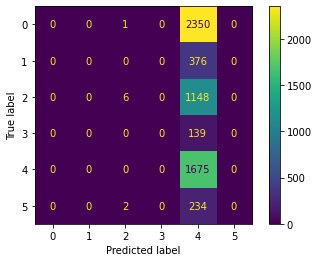

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_dict)
disp.plot()
plt.show()

We show some predictions for new texts. The second prediction is wrong (the news is fake). 

In [45]:
text = "Donald Trump sent his own plane to transport 200 stranded marines."

pred=get_prediction(text)
print('class:', labels_dict[pred])

text = "euro values more than dolar"

pred=get_prediction(text)
print('class:', labels_dict[pred])

tensor([[2.8578e-02, 1.5175e-02, 2.1648e-01, 6.3286e-04, 7.3887e-01, 2.5964e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
class: False Connection
tensor([[3.4225e-02, 2.8503e-02, 8.6446e-02, 4.5631e-04, 8.4999e-01, 3.7789e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
class: False Connection
